# Lab 4: Working with 'real' data
### By: Evelena Burunova

In this lab we will be learning to estimate the background from 'real' data.

In [165]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

plt.rcParams["figure.figsize"] = (20,15)

hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys()
data = np.array(hf.get('data'))
print(data.shape)

(4, 25920001)


### Problem 1
In this problem we will look at data from a gamma-ray satellite orbiting in low Earth orbit (approximately a 90 minute orbit). This satellite takes a reading of the number of particles detected every 100 milliseconds. The particles detected are essentially background cosmic rays even though the satellite looks for gamma-ray bursts. <br>
<br>
The first step is to download the data: 'gammaray_lab4.h5'<br>
This data contains 4 columns and more than 25 million rows. The 4 columns are: time (seconds), Solar phase (degrees) showing position of sun relative to orbit, Earth longitude (degree) showing position of spacecraft relative to ground, and particle counts. <br>
<br>
We will make a few plots to explore the data. 
We will take the first 400,000 measurements and plot them. 

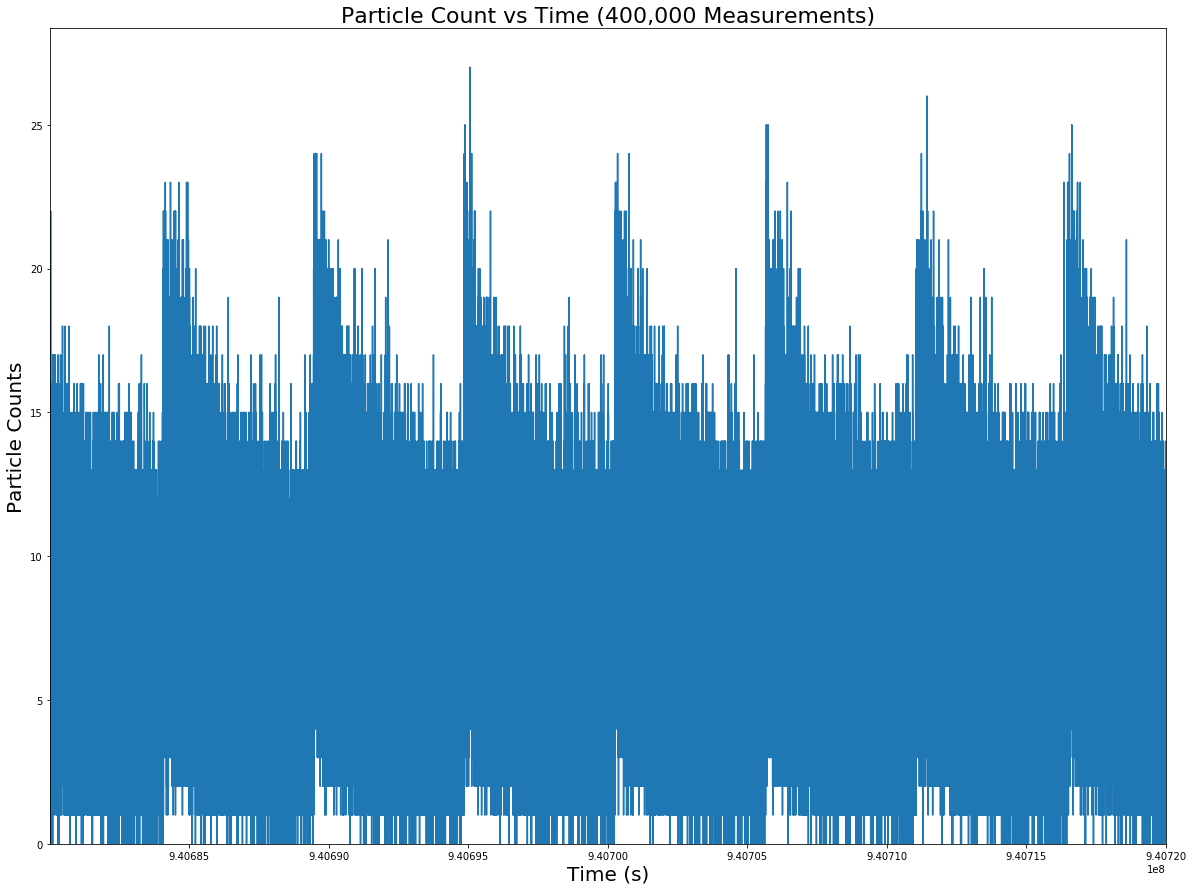

In [166]:
num_points = 400000
#particle counts
x = data[0][0:num_points]
y = data[3][0:num_points]

plt.plot(x,y)
plt.title('Particle Count vs Time (400,000 Measurements)', size=22)
plt.xlabel('Time (s)', size =20)
plt.ylabel('Particle Counts', size=20)
plt.xlim(data[0][0], data[0][num_points])
plt.ylim(0, None)
plt.show()


Observing the plot above we can see that there are spikes in the measurements making the data not random. We can see that the spikes in the data are somewhat periodic meaning there is some sort of  additonal interference/radiation during the orbit. The spikes appear due to a weaker earth's magnetic field at a certain point which results in more particle counts recieved by the satellite.  <br>
<br>

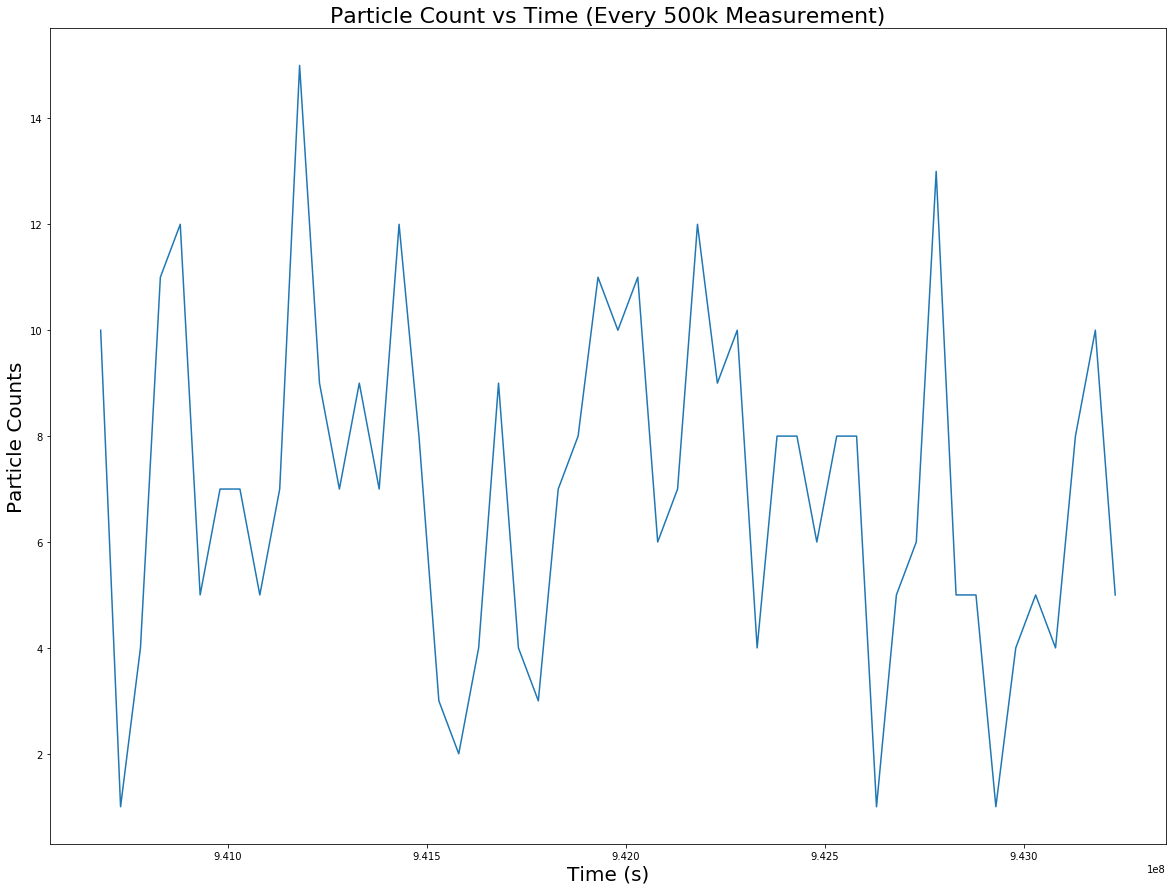

In [168]:
total_rows = 25920001
x4 = data[0][0: total_rows -1: 500000]
y4 = data[3][0: total_rows -1: 500000]
plt.plot(x4,y4)
plt.title('Particle Count vs Time (Every 500k Measurement)', size=22)
plt.xlabel('Time (s)', size =20)
plt.ylabel('Particle Counts', size=20)
plt.show()

Next, we will plot the histrogram of this data to observe the distribution. <br>

Text(0.5, 0, 'Particle Counts')

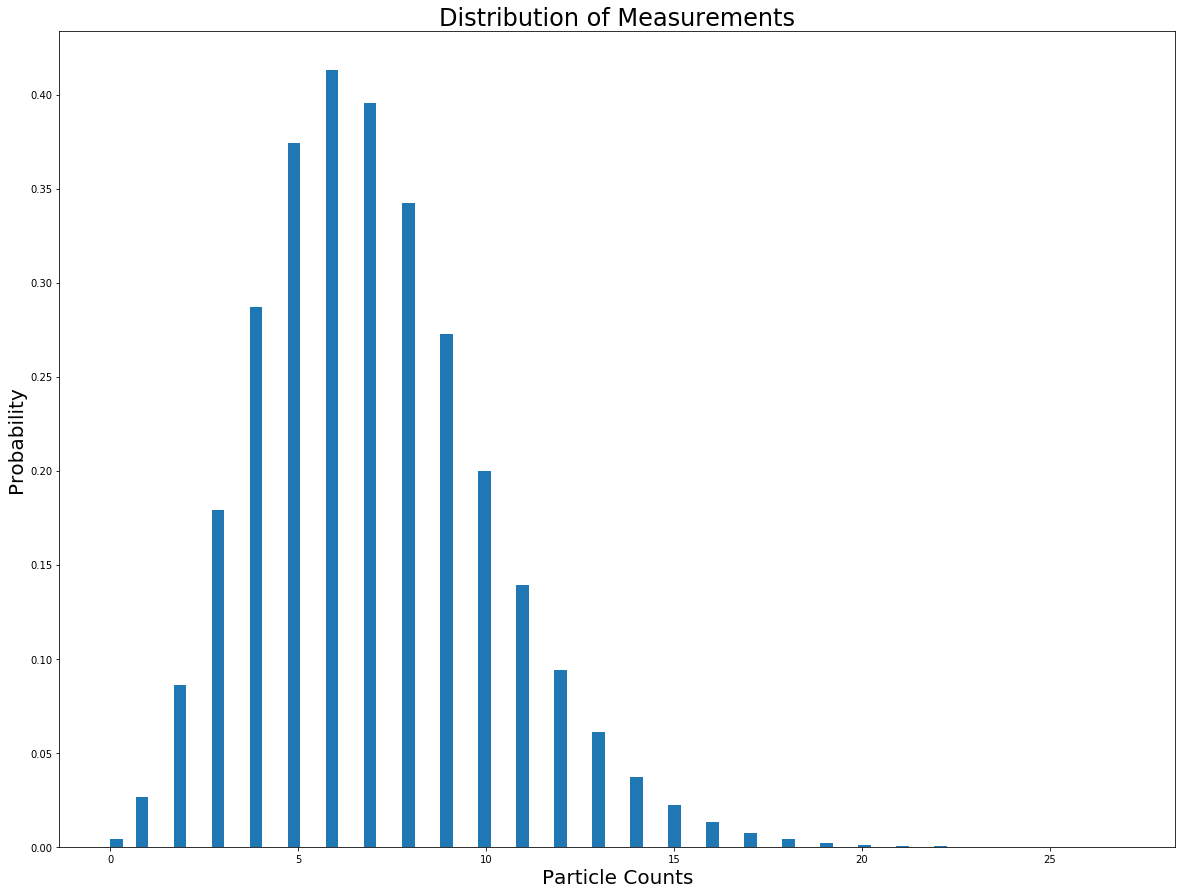

In [170]:
plt.hist(y, bins = 80, density= True)
plt.title('Distribution of Measurements', size=24)
plt.ylabel('Probability', size=20)
plt.xlabel('Particle Counts', size=20)

Observing the plot above we can see that the data is represented by a discete distribution. Where the particle count represents a number of events in a specified time frame. The plot above looks like a Poisson distribution where the lamda (mean) is around 6. To check whether or not the data in fact represents a poisson distribution we will plot with a semi-log scale and compare it with the poisson distribution. 

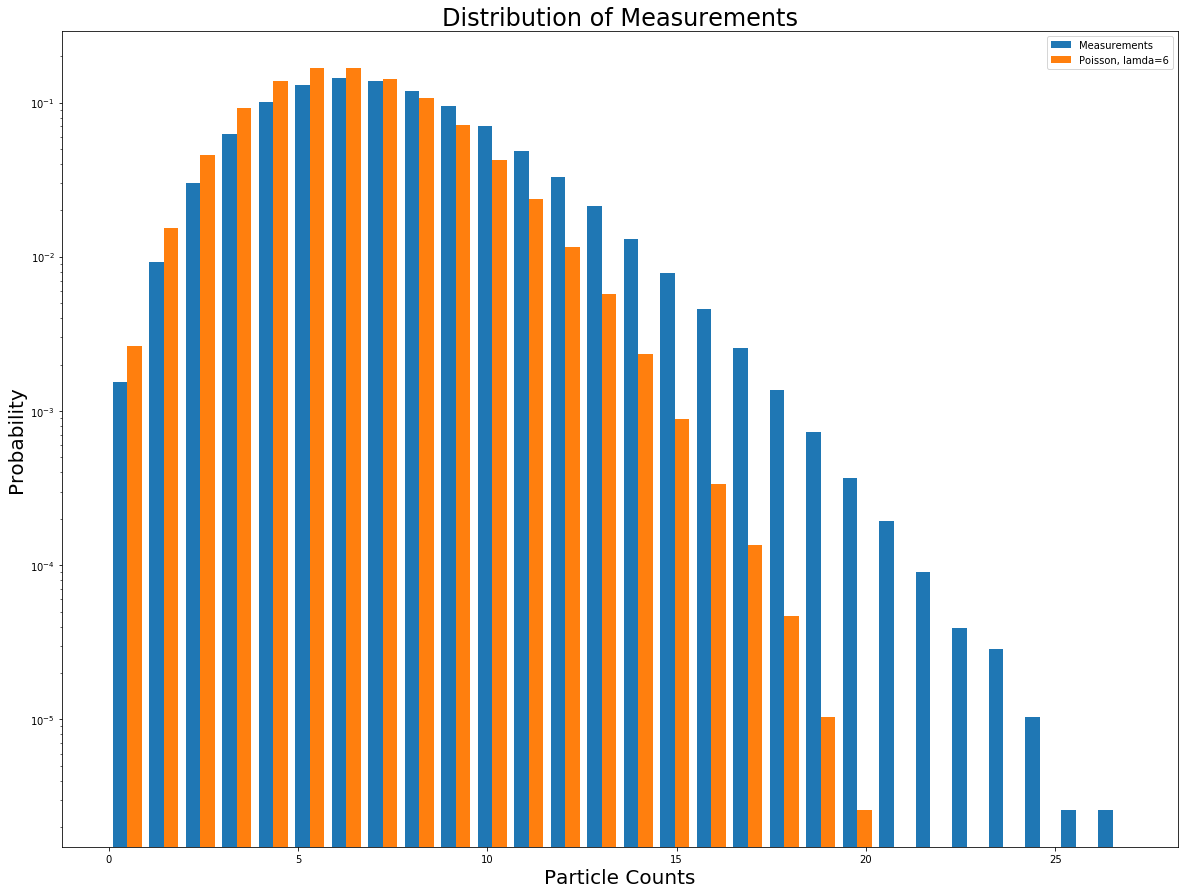

In [171]:
d = stats.poisson(6)
n = d.rvs(num_points)
plt.hist([y, n], bins = 28, density= True)
plt.yscale('log')
plt.title('Distribution of Measurements', size=24)
plt.ylabel('Probability', size=20)
plt.xlabel('Particle Counts', size=20)
plt.legend(['Measurements', 'Poisson, lamda=6'])

As we can see from the plot above the data is not represented by a Poisson distribution. We can see that our data has a higher particle count. As a result, there is definitely some sort of signal contamination which we will explore next.

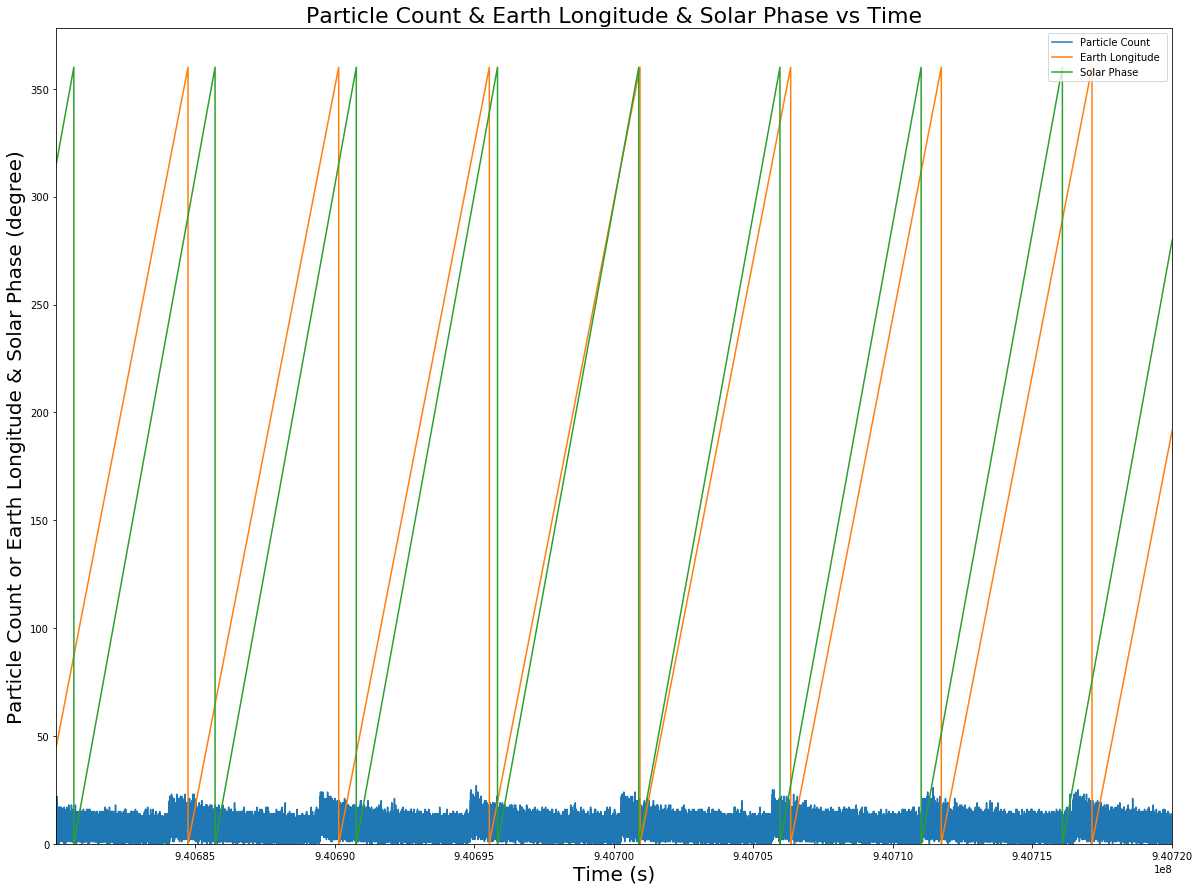

In [172]:
#earth longitude
x2 = data[0][0:num_points]
y2 = data[2][0:num_points]
#solar phase
x3 = data[0][0:num_points]
y3 = data[1][0:num_points]

plt.plot(x,y)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.legend(['Particle Count',"Earth Longitude ", "Solar Phase"], loc='upper right')
plt.title('Particle Count & Earth Longitude & Solar Phase vs Time', size=22)
plt.xlabel('Time (s)', size =20)
plt.ylabel('Particle Count or Earth Longitude & Solar Phase (degree)', size=20)
plt.xlim(data[0][0], data[0][num_points])
plt.ylim(0, None)
plt.show()

With the plot above, we can see that there is an alignment between the periodic spikes in our data and the longitude with a slight phase offset. We can see that the solar phase doesn't seem to share a relationship with the periodic jumps, therefore is negligible with our next task. Due to there being an alignment between the periodic spikes and the earth's longitude we can assume that there is an issue with the location. As a result, to better fit our distribution we can split the data into two parts. The South Atlantic Anomaly region ranges between 310 degrees and 40 degress. 


In order to make the graph fit better we can split the data into two part. Assuming that SAA region is between 40 degrees and 310 degrees earth longitude we can split out data into parts that are outside and inside the SAA.

Text(0, 0.5, 'Counts')

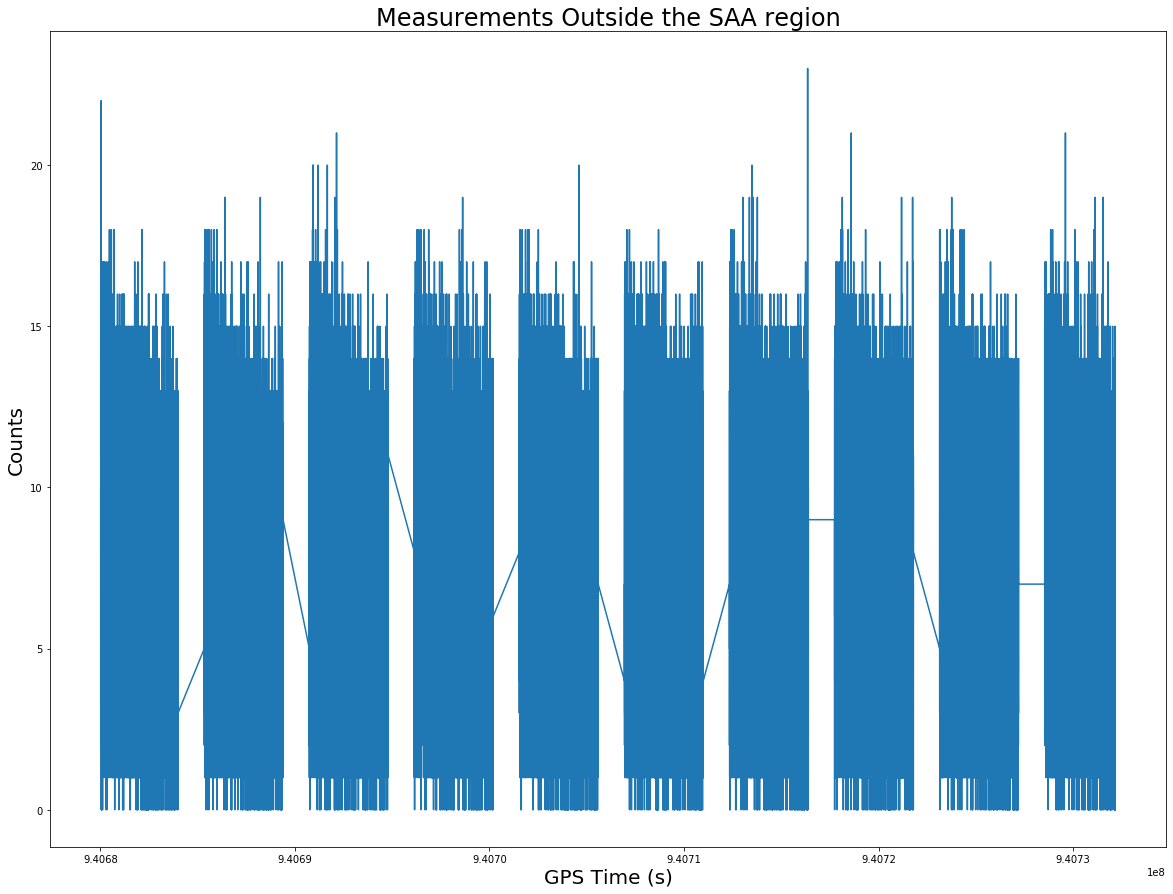

In [173]:
n = ((data[2] > 40) & (data[2] < 310))
time = data[0][n]
counts = data[3][n]

xx = time[0:num_points]
yy = counts[0:num_points]

plt.plot(xx,yy)
plt.title( "Measurements Outside the SAA region", size=24)
plt.xlabel('GPS Time (s)', size=20)
plt.ylabel('Counts', size=20)

The part outside the SAA region has the less particle counts

Text(0.5, 1.0, 'Distribution of Measurements Outside SAA Region')

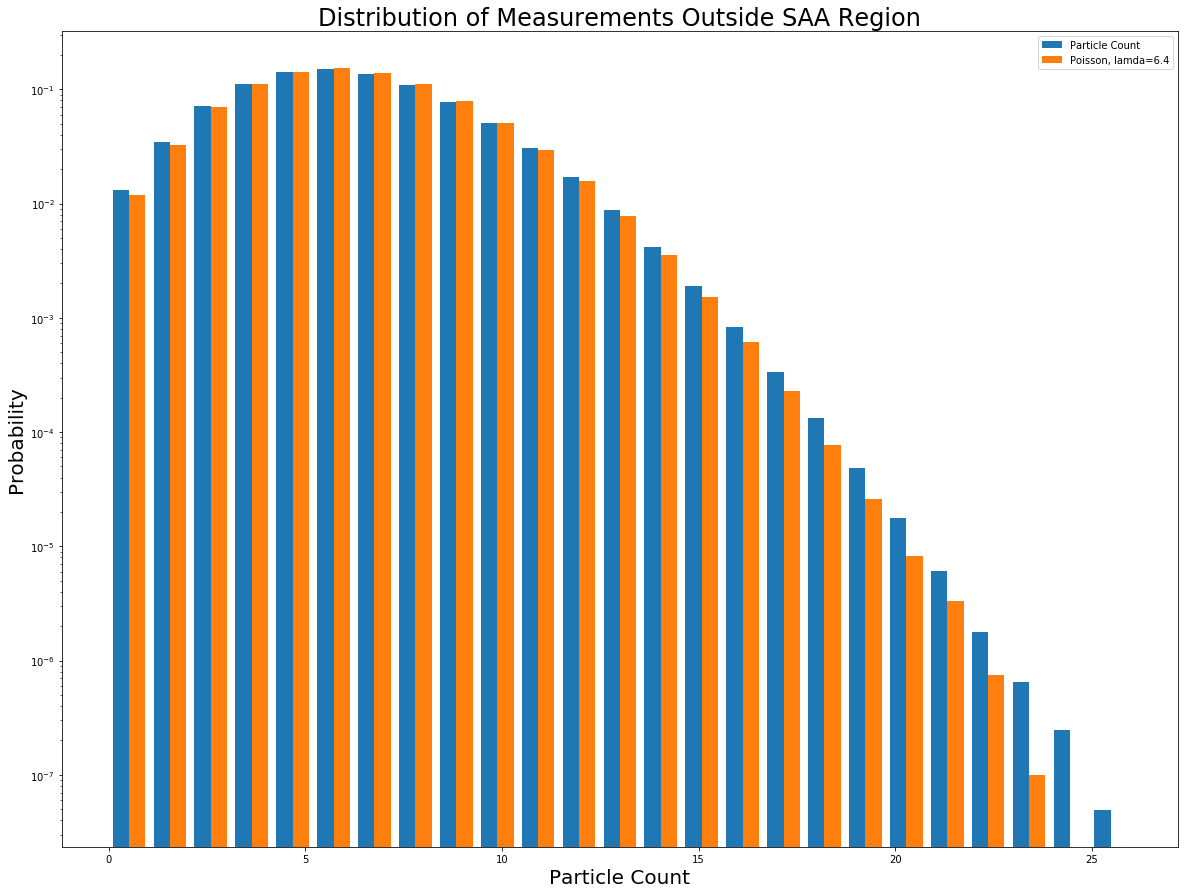

In [174]:
mean_saa = np.mean(counts)
rounded_m = mean_saa.round(1)
v = stats.poisson(mean_saa).rvs(len(counts))
plt.hist([counts,v], bins = 25, density=True)
plt.yscale('log')
plt.legend(['Particle Count', "Poisson, lamda=" + str(rounded_m)])
plt.xlabel('Particle Count', size=20)
plt.ylabel('Probability', size=20)
plt.title('Distribution of Measurements Outside SAA Region', size=24)

Now that we plotted all the measurements outside the SAA, we can observe that this distribution does in fact resemble the Poisson distrubition with a lambda value of 6.4. <br>
<br>
Using the ppf function we are able to determine the signal treshold to locate the 5sigma events.

In [175]:
no = stats.norm.cdf(5)
d =stats.poisson(rounded_m).ppf(no)
print(d)

23.0


The smallest signal needed to consider a measurement outside the SAA to have a significance of 5sigma would be 22 counts. <br>
<br>
Next, let's plot the inside the SAA region

Text(0, 0.5, 'Counts')

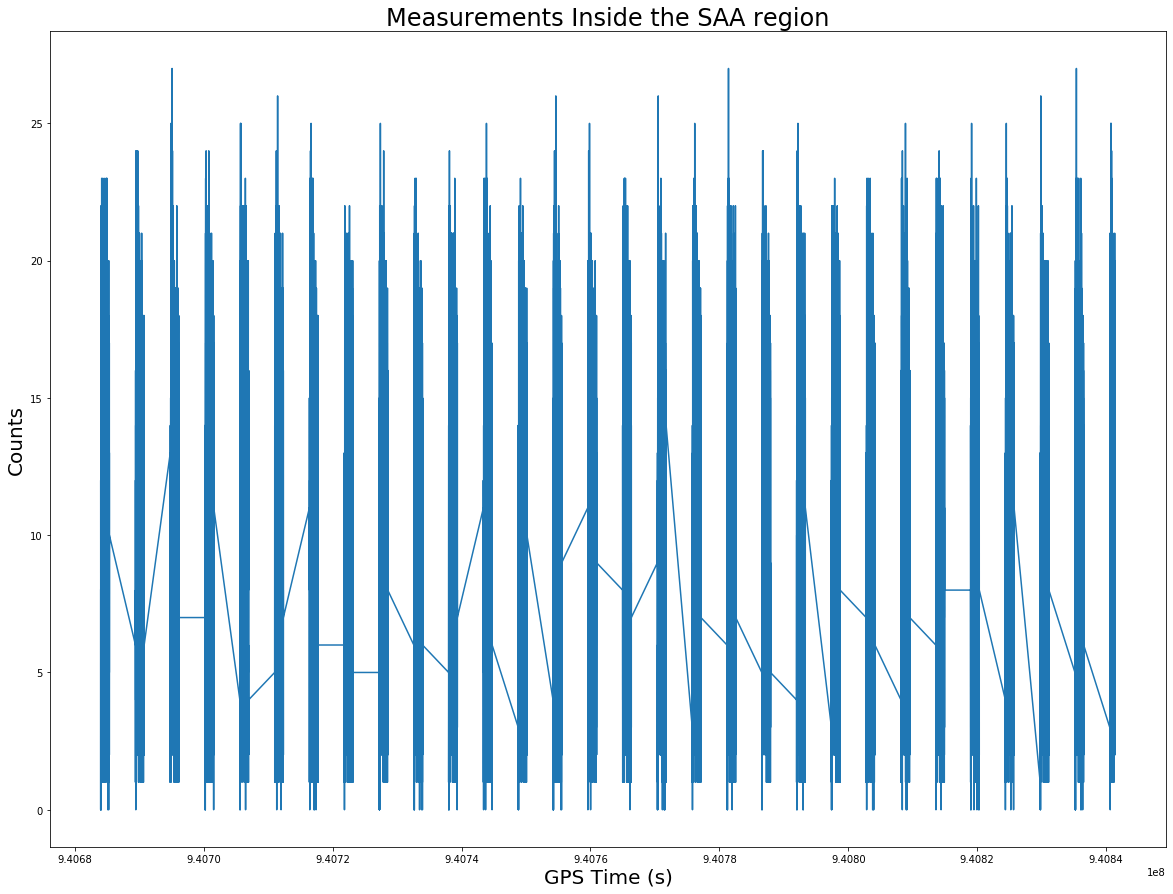

In [176]:
saa_time = data[0][np.invert(n)]
saa_counts = data[3][np.invert(n)]

xx2 = saa_time[0:num_points]
yy2 = saa_counts[0:num_points]
plt.plot(xx2,yy2)
plt.title( "Measurements Inside the SAA region", size=24)
plt.xlabel('GPS Time (s)', size=20)
plt.ylabel('Counts', size=20)

The part inside the SAA region has higher particle counts. 

Text(0.5, 1.0, 'Distribution of Measurements Inside SAA Region')

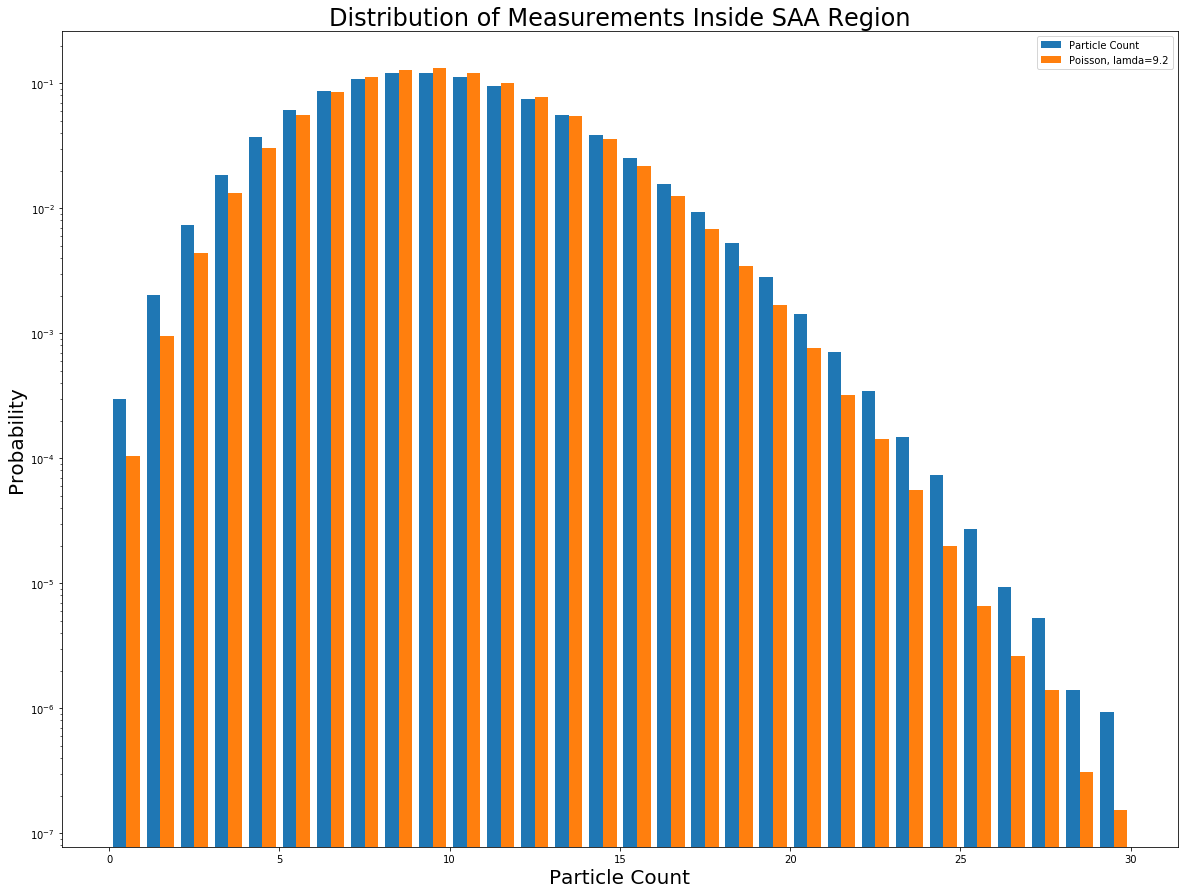

In [177]:
mean_saa2 = np.mean(saa_counts)
rounded_m2 = mean_saa2.round(1)
v2 = stats.poisson(mean_saa2).rvs(len(saa_counts))
plt.hist([saa_counts,v2], bins = 30, density=True)
plt.yscale('log')
plt.legend(['Particle Count', "Poisson, lamda=" + str(rounded_m2)])
plt.xlabel('Particle Count', size=20)
plt.ylabel('Probability', size=20)
plt.title('Distribution of Measurements Inside SAA Region', size=24)

The plot above that shows the distribution of measurements inside the SAA region does in fact resemble a Poisson distribution with a lambda value of 9.2 per 100 milliseconds. <br>
<br>
Again, to determine the 5sigma threshold we will use the ppf function

In [178]:
no = stats.norm.cdf(5)
d =stats.poisson(rounded_m2).ppf(no)
print(d)

28.0


The smallest signal needed to consider a measurement inside the SAA to have a significance of 5sigma would be 28 counts.

### Problem 2
In this problem we will look at a stack of simulated telescope images. Here, we have 10 images and we will look for transient signals (supernovae) amongst the background. <br>
<br>
First begin by downloading the data 'image.h5' This is a stack of 10 square images, each 200 pixels on the side. <br>
<br>
Next, we will explore the data.

In [179]:
hf2 = h5py.File('images.h5', 'r')
print(hf2.keys())

data = np.array(hf2.get('imagestack'))
print(data.shape)

<KeysViewHDF5 ['image1', 'imagestack']>
(200, 200, 10)


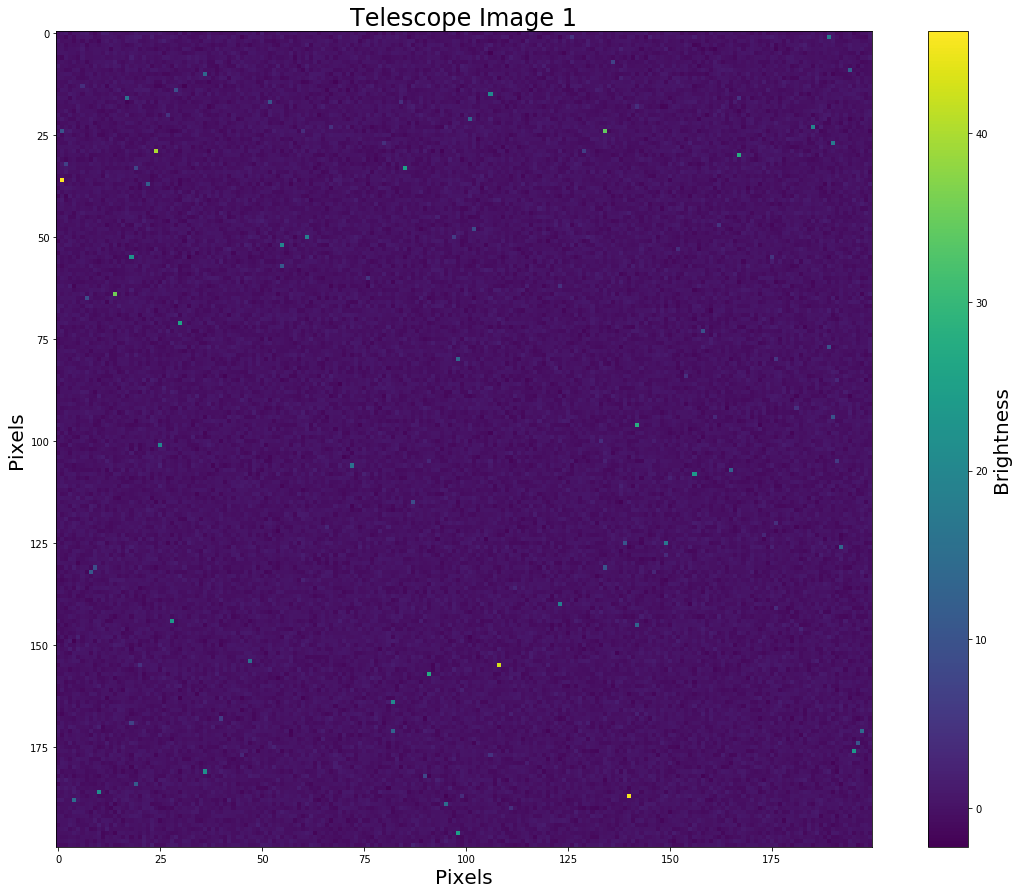

In [194]:
plt.imshow(data[:, :, 0])
plt.title('Telescope Image 1', size =24)
plt.xlabel('Pixels', size = 20)
plt.ylabel('Pixels', size=20)
cbar = plt.colorbar()
cbar.set_label('Brightness', size = 20)

The plot above shows the spatial distribution of the first telescope image. The label shows the brightness variation that varies from purple to yellow. With purple being the faintest and yellow being the brightest. <br>
<br>
As we can observe most of the image is dark (purple).